# 怎么做

- 先撸一个baseline的model出来，再进行后续的分析步骤，一步步提高
- 经验
    - 1 对数据的认识太重要了
    - 2 数据中的特殊点/离群点的分析和处理太重要了
    - 3 特征工程(feature engineering)太重要了！甚至比model本身还要重要
    - 4 要做模型融合(model ensemble)

# 初探数据

In [1]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame

data_train = pd.read_csv("input/train.csv")
print(data_train.columns)
print(data_train.iloc[0:3, :])

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  


## 列数据信息：

- PassengerId => 乘客ID
- Pclass => 乘客等级(1/2/3等舱位)
- Name => 乘客姓名
- Sex => 性别
- Age => 年龄
- SibSp => 堂兄弟/妹个数
- Parch => 父母与小孩个数
- Ticket => 船票信息
- Fare => 票价
- Cabin => 客舱
- Embarked => 登船港口

## 用DataFrame的info()方法获取信息

In [16]:
print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


### 缺失值

- Age 只有714名乘客有记录
- Cabin 只有204名乘客是已知的

## 用describe()方法获取信息

In [18]:
print(data_train.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000         NaN    0.000000   
50%     446.000000    0.000000    3.000000         NaN    0.000000   
75%     668.500000    1.000000    3.000000         NaN    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


# 数据初步分析

## 乘客各属性分布

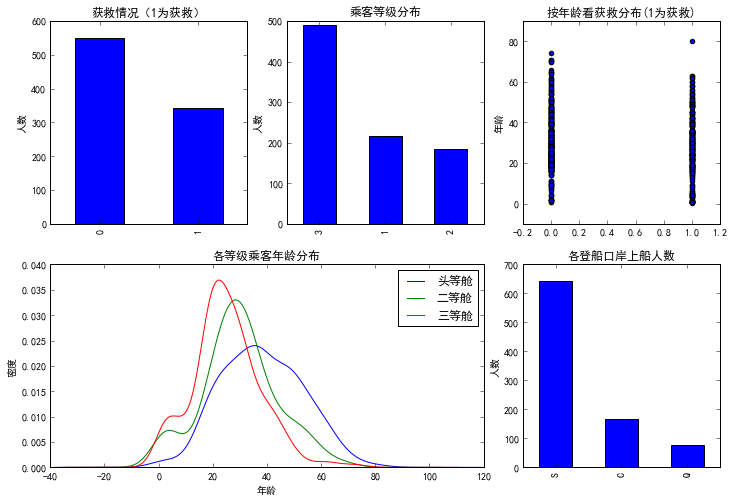

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
fig.set(alpha=0.1)

plt.subplot2grid((2, 3), (0, 0))
# 柱状图
data_train.Survived.value_counts().plot(kind="bar")
plt.title("获救情况（1为获救）")
plt.ylabel("人数")

plt.subplot2grid((2, 3), (0, 1))
data_train.Pclass.value_counts().plot(kind="bar")
plt.ylabel("人数")
plt.title("乘客等级分布")

plt.subplot2grid((2, 3), (0, 2))
plt.scatter(data_train.Survived, data_train.Age)
plt.ylabel("年龄")
plt.title("按年龄看获救分布(1为获救)")

plt.subplot2grid((2, 3), (1, 0), colspan=2)
data_train.Age[data_train.Pclass == 1].plot(kind="kde")
data_train.Age[data_train.Pclass == 2].plot(kind="kde")
data_train.Age[data_train.Pclass == 3].plot(kind="kde")
plt.title("各等级乘客年龄分布")
plt.xlabel("年龄")
plt.ylabel("密度")
plt.legend(("头等舱", "二等舱", "三等舱"), loc="best")

plt.subplot2grid((2, 3), (1, 2))
data_train.Embarked.value_counts().plot(kind="bar")
plt.title("各登船口岸上船人数")
plt.ylabel("人数")

plt.show()

## 属性与获救结果的关联统计

看看各乘客等级的获救情况

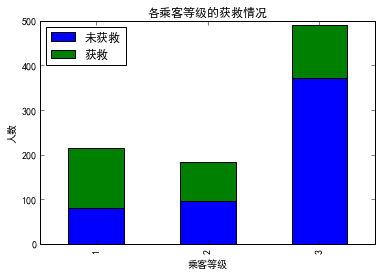

In [23]:
Survived_0 = data_train.Pclass[data_train.Survived == 0].value_counts()
Survived_1 = data_train.Pclass[data_train.Survived == 1].value_counts()
df = pd.DataFrame({"获救": Survived_1, "未获救": Survived_0})
df.plot(kind="bar", stacked=True)
plt.title("各乘客等级的获救情况")
plt.xlabel("乘客等级")
plt.ylabel("人数")
plt.show()

看看性别的获救情况

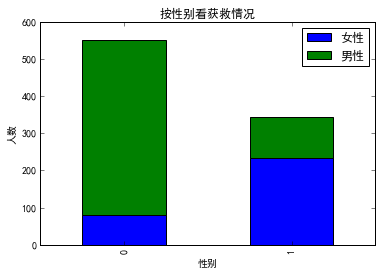

In [31]:
Survived_f = data_train.Survived[data_train.Sex == "female"].value_counts()
Survived_m = data_train.Survived[data_train.Sex == "male"].value_counts()
df = pd.DataFrame({"男性": Survived_m, "女性": Survived_f})
df.plot(kind="bar", stacked=True)
plt.title("按性别看获救情况")
plt.xlabel("性别")
plt.ylabel("人数")
plt.show()

详细版的性别和舱级别的获救情况

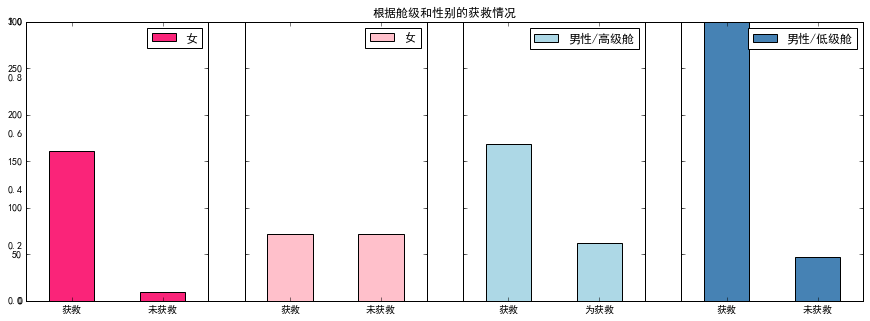

In [53]:
fig = plt.figure(figsize=(15, 5))
plt.title("根据舱级和性别的获救情况")
plt.xticks(())

ax1 = fig.add_subplot(141)
data_train.Survived[data_train.Sex == "female"][data_train.Pclass != 3] \
    .value_counts().plot(kind="bar", label="female higclass", color="#FA2479")
ax1.set_xticklabels(["获救", "未获救"], rotation=0)
ax1.legend(("女性/高级舱"), loc="best")

ax2 = fig.add_subplot(142, sharey=ax1)
data_train.Survived[data_train.Sex == "female"][data_train.Pclass == 3] \
    .value_counts().plot(kind="bar", label="female lowclass", color="pink")
ax2.set_xticklabels(["获救", "未获救"], rotation=0)
ax2.legend(("女性/低级舱"), loc="best")

ax3 = fig.add_subplot(143, sharey=ax1)
data_train.Survived[data_train.Sex == "male"][data_train.Pclass != 3] \
    .value_counts().plot(kind="bar", label="male higclass", color="lightblue")
ax3.set_xticklabels(["获救", "为获救"], rotation=0)
ax3.legend(["男性/高级舱"], loc="best")

ax4 = fig.add_subplot(144, sharey=ax1)
data_train.Survived[data_train.Sex == "male"][data_train.Pclass == 3] \
    .value_counts().plot(kind="bar", label="male lowclass", color="steelblue")
ax4.set_xticklabels(["获救", "未获救"], rotation=0)
ax4.legend(["男性/低级舱"], loc="best")

plt.show()

各登船港口的收获情况

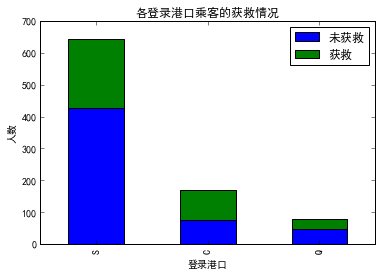

In [4]:
Survived_0 = data_train.Embarked[data_train.Survived == 0].value_counts()
Survived_1 = data_train.Embarked[data_train.Survived == 1].value_counts()
df = pd.DataFrame({"获救": Survived_1, "未获救": Survived_0})
df.plot(kind="bar", stacked=True)
plt.title("各登录港口乘客的获救情况")
plt.xlabel("登录港口")
plt.ylabel("人数")
plt.show()

看看堂兄弟/妹，孩子/父母有几人，对是否获救的影响

In [5]:
g = data_train.groupby(["SibSp", "Survived"])
df = pd.DataFrame(g.count()["PassengerId"])
print(df)

                PassengerId
SibSp Survived             
0     0                 398
      1                 210
1     0                  97
      1                 112
2     0                  15
      1                  13
3     0                  12
      1                   4
4     0                  15
      1                   3
5     0                   5
8     0                   7


看看客舱的数据

In [6]:
print(data_train.Cabin.value_counts())

B96 B98            4
G6                 4
C23 C25 C27        4
F33                3
E101               3
F2                 3
C22 C26            3
D                  3
C123               2
D35                2
B57 B59 B63 B66    2
C93                2
E25                2
E24                2
B28                2
C65                2
B58 B60            2
D33                2
B5                 2
B51 B53 B55        2
C125               2
E8                 2
C92                2
C83                2
C78                2
C2                 2
F G73              2
C52                2
B77                2
B35                2
                  ..
C103               1
B101               1
D48                1
B69                1
E68                1
A5                 1
B39                1
B94                1
C87                1
A23                1
C62 C64            1
E58                1
B37                1
C128               1
D21                1
C91                1
B78          

因为Cabin直接按类别分太散，估计每个因子化后的特征都拿不到什么权重，缺失值又多，暂且将缺失与否作为条件

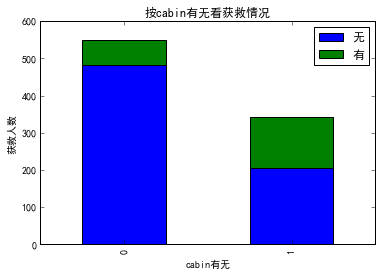

In [13]:
Survive_cabin = data_train.Survived[pd.notnull(data_train.Cabin)].value_counts()
Survive_nocabin = data_train.Survived[pd.isnull(data_train.Cabin)].value_counts()
df = pd.DataFrame({"有": Survive_cabin, "无": Survive_nocabin})
df.plot(kind="bar", stacked=True)

plt.title("按cabin有无看获救情况")
plt.xlabel("cabin有无")
plt.ylabel("获救人数")
plt.show()

# 简单数据预处理

## 缺失值的处理

- 如果缺值的样本占总数比例极高，我们可能就直接舍弃了
- 如果缺值的样本适中，而该属性非连续值特征属性，那就把NaN作为一个新类别
- 如果缺值的样本适中，而该属性为连续值特征属性，有时候我们会考虑给定一个step，然后把它离散化，之后把NaN作为一个type加到属性类目中
- 缺失的值个数并不是特别多，那我们也可以试着根据已有的值，拟合一下数据，补充上

使用RandomForest来拟合缺失的年龄数据

In [20]:
from sklearn.ensemble import RandomForestRegressor

# 使用RandomForestClassifier填补缺失的年龄属性
def set_missing_ages(df):
    # 把已有的数值型特征取出来丢进Random Forest Regressor中
    age_df = df[["Age", "Fare", "Parch", "SibSp", "Pclass"]]
    
    # 乘客分为已知年龄和未知年龄两部分
    known_age = age_df[age_df.Age.notnull()].as_matrix()
    unknown_age = age_df[age_df.Age.isnull()].as_matrix()
    
    # y即目标年龄
    y = known_age[:, 0]
    # X即特征属性值
    X = known_age[:, 1:]
    
    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)
    
    # 用得到的模型进行未知年龄预测
    predictedAges = rfr.predict(unknown_age[:, 1::])

    # 用得到的预测结果填补原缺失数据
    return df, rfr

def  set_Cabin_type(df):
    df.loc[(df.Cabin.notnull()), "Cabin"] = "Yes"
    df.loc[(df.Cabin.isnull()), "Cabin"] = "No"
    return df

data_train, rfr = set_missing_ages(data_train)
data_train = set_Cabin_type(data_train)
print(data_train[:3])

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   Yes        S  
1      0          PC 17599  71.2833   Yes        C  
2      0  STON/O2. 3101282   7.9250   Yes        S  
